In [1]:
import timm
from PIL import Image
import torch
from torchvision import transforms
from torch.nn import functional as F
import timm.models.mlp_mixer
import numpy as np
import exchange_tensor_array as exchange
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision.datasets.utils import download_url
import json

import copy
#モデル作成
model = timm.create_model("gmlp_s16_224", pretrained=True)
model.eval()
print("model")

transform = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
        transforms.ToTensor(),  # テンソルにする。
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # 標準化する。
    ]
)

transform_beta = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
    ]
)

img = Image.open("cat.jpg")
inputs = transform(img)
inputs = inputs.unsqueeze(0)
#plt.imshow(inputs[0].permute(1,2,0))
copy_inputs = copy.deepcopy(inputs)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model


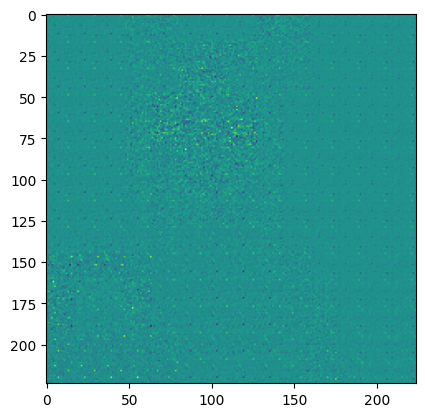

In [2]:
output0 = model(inputs)
mid0 = model.blocks[0].block_output
mid0 = exchange.exchange_tensor_to_array(mid0)
plt.imshow(mid0)

225


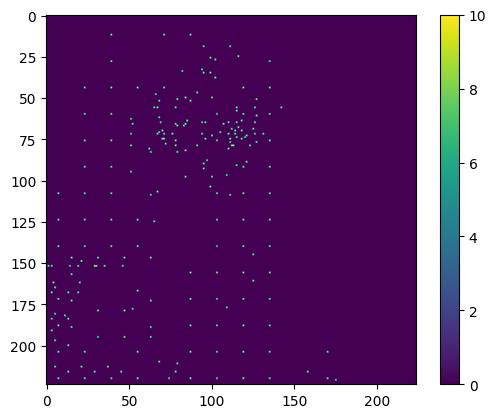

In [25]:
from sklearn.cluster import DBSCAN
y, x = np.where((abs(mid0) > 3))
l = len(y)
p = [ [y[i], x[i]] for i in range(l)]
print(l)
tmp = np.zeros((224, 224))
for u, v in p:
    tmp[u, v] = 10
exchange.show_heatmap_with_colorbar(tmp)


0.0 50176


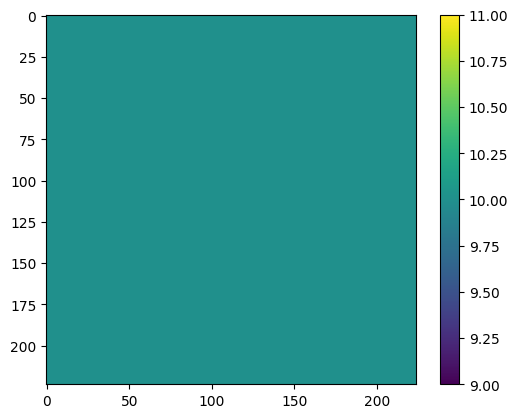

0.2 25151


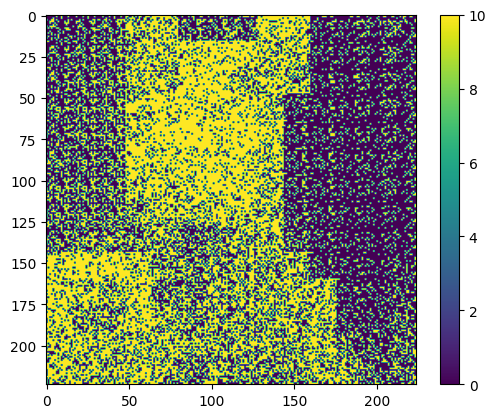

0.4 14211


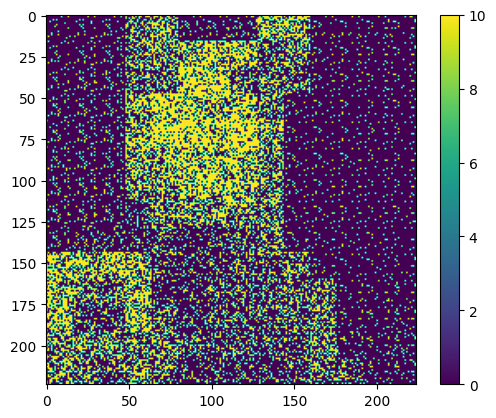

0.6000000000000001 8686


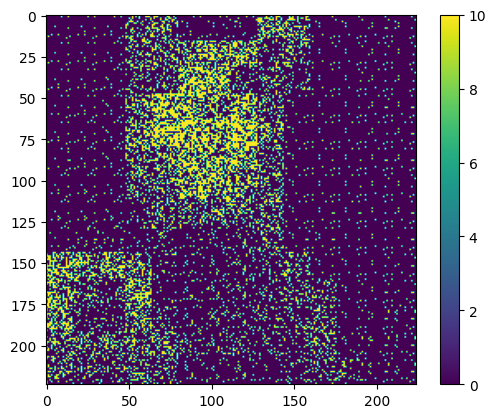

0.8 5665


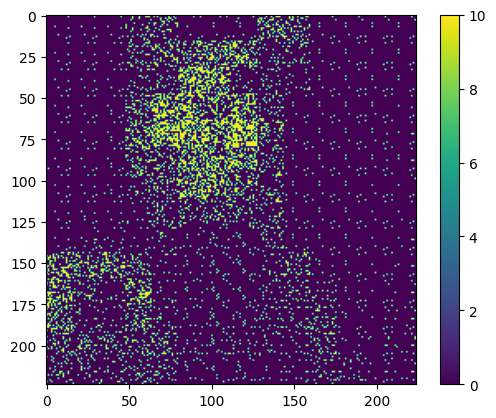

1.0 3845


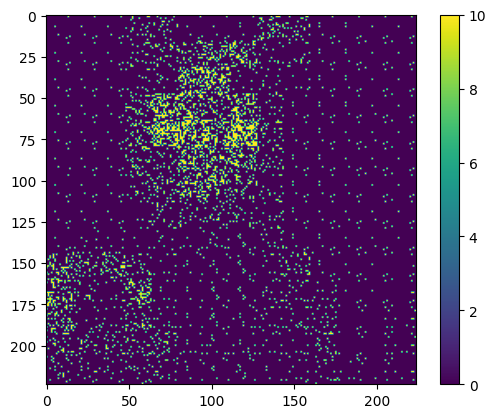

1.2000000000000002 2693


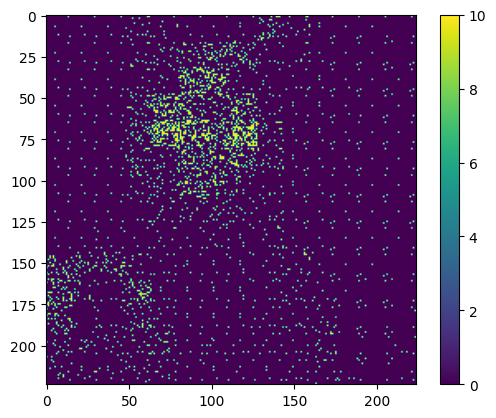

1.4000000000000001 1939


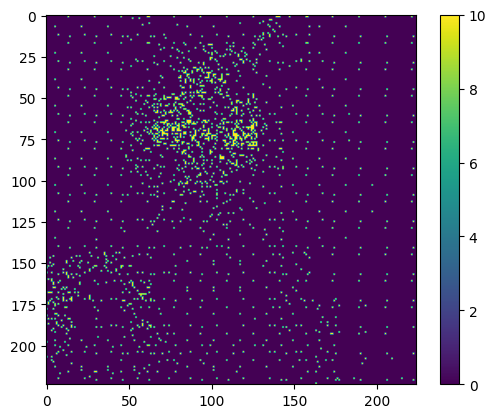

1.6 1474


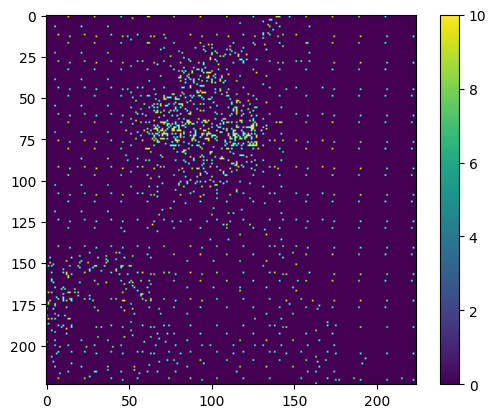

1.8 1095


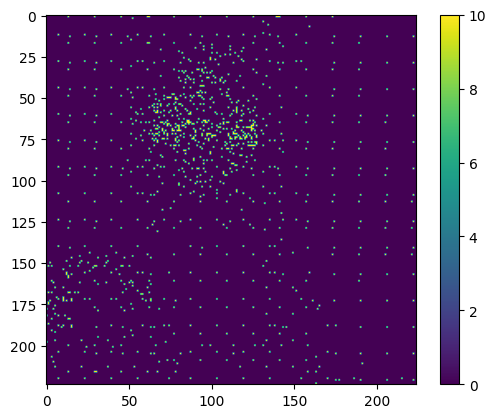

2.0 829


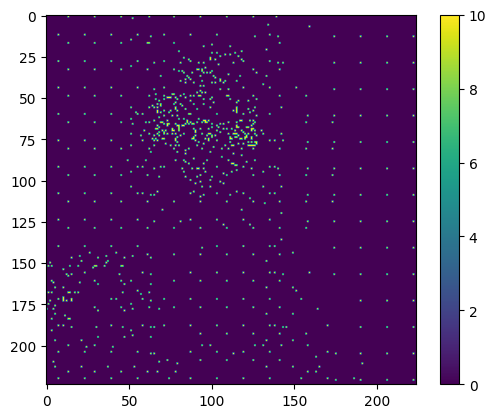

2.2 625


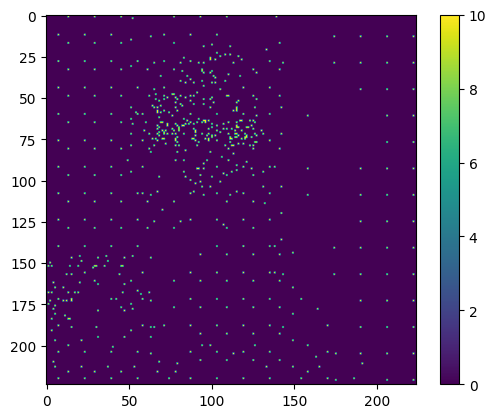

2.4000000000000004 477


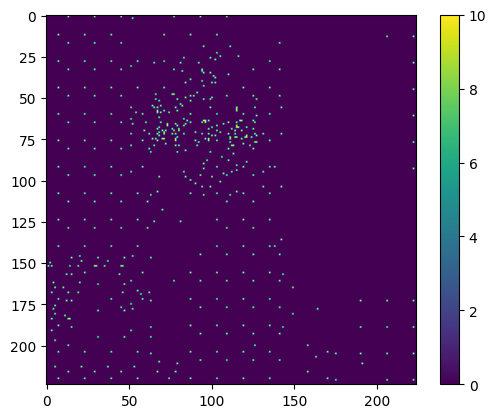

2.6 359


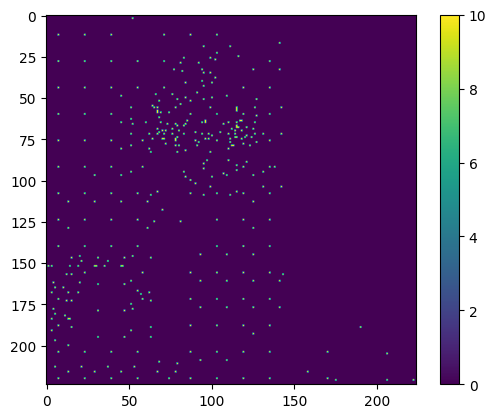

2.8000000000000003 283


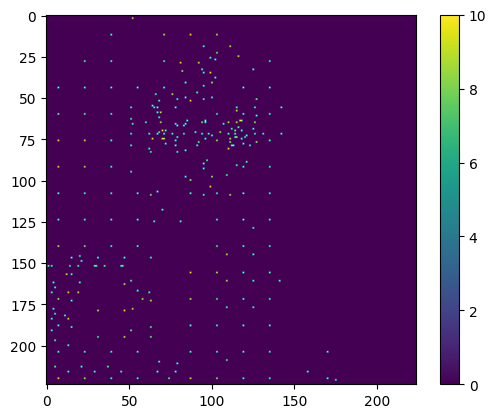

3.0 225


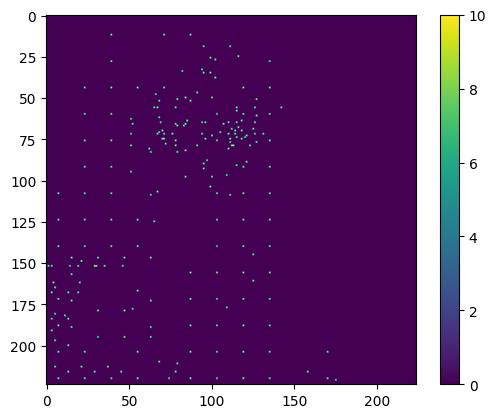

3.2 174


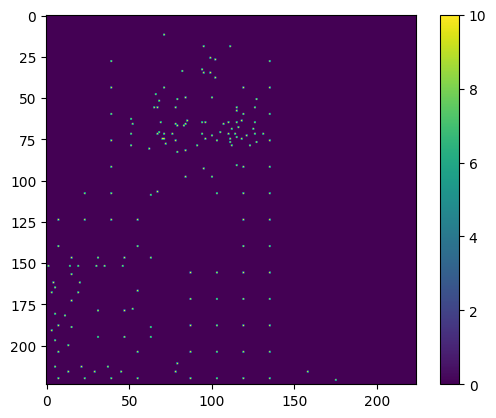

3.4000000000000004 140


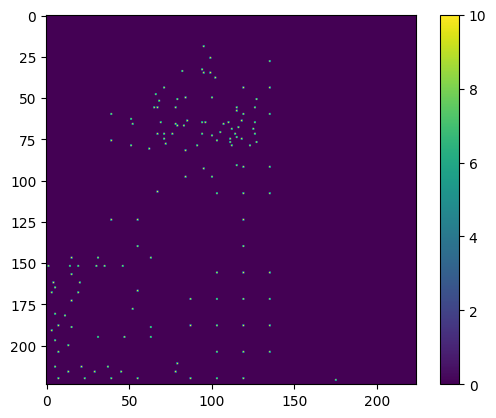

3.6 106


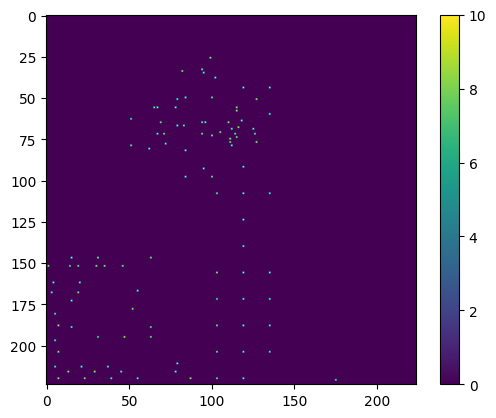

3.8000000000000003 95


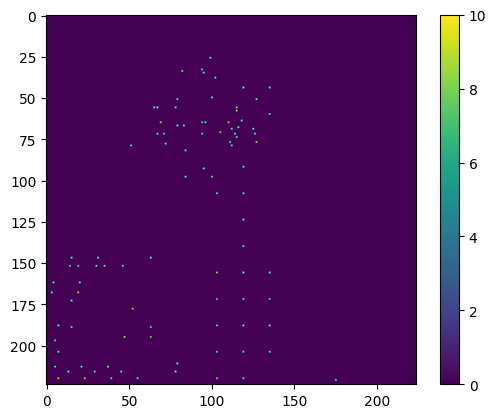

4.0 80


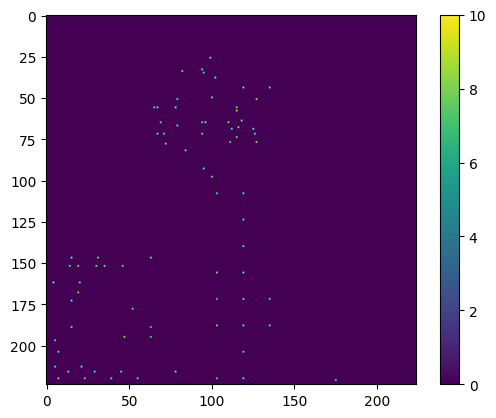

4.2 66


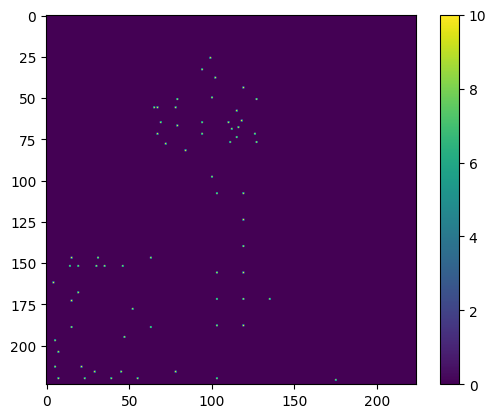

4.4 54


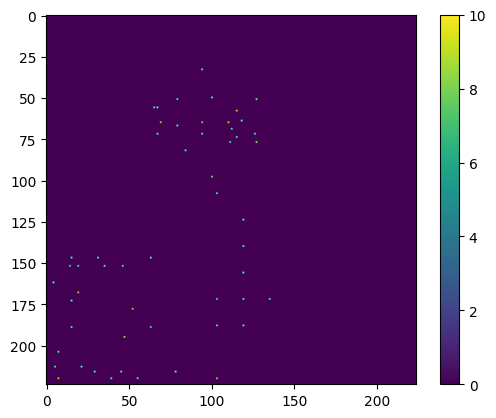

4.6000000000000005 40


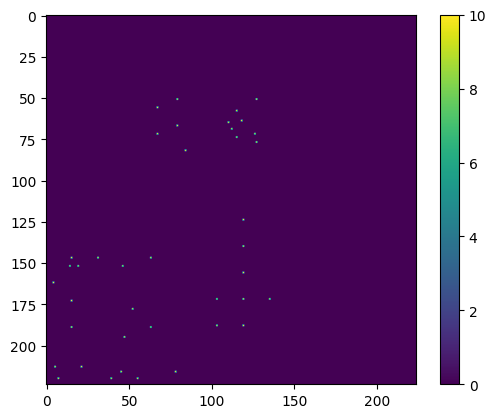

4.800000000000001 27


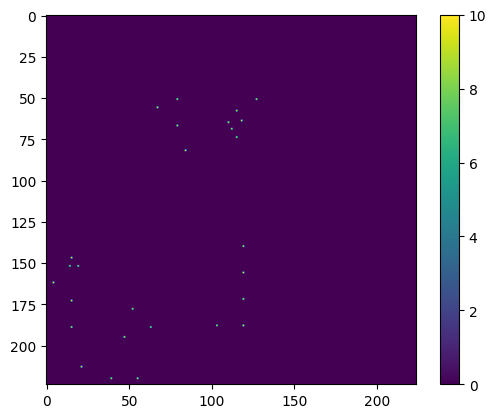

In [30]:
for i in range(0, 50, 2):
    y, x = np.where((abs(mid0) > i * 0.1))
    print(i * 0.1, len(y))
    tmp = np.zeros((224, 224))
    for u, v in zip(y, x):
        tmp[u, v] = 10
    exchange.show_heatmap_with_colorbar(tmp)

In [70]:
y, x = np.where((abs(mid0) > 2.75))
l = len(y)
p = [ [y[i], x[i]] for i in range(l)]
print(l)

297


14

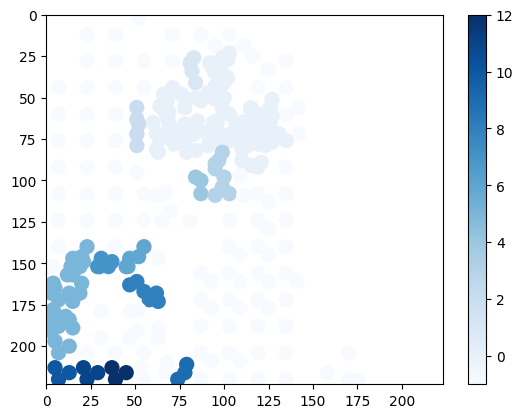

In [71]:
db = DBSCAN(eps=8, min_samples=3)
pred = db.fit_predict(p)
n_c = set(pred)
fig, ax = plt.subplots()
plt.scatter(x, y, s=100, c=pred, cmap="Blues")
plt.colorbar()
plt.xlim(0, 223)
plt.ylim(223, 0)
len(set(pred))

In [15]:
import hdbscan
hdb = hdbscan.HDBSCAN()
hdb.fit(p)

HDBSCAN()

65
20
13
7
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1


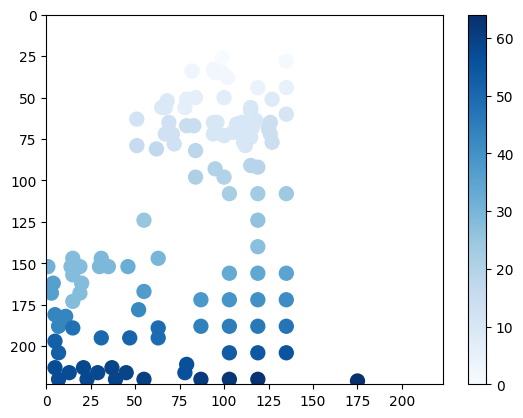

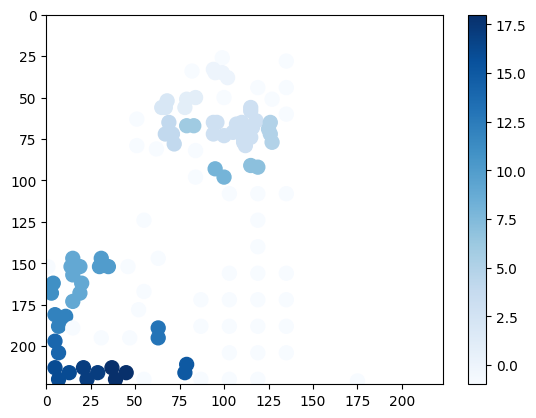

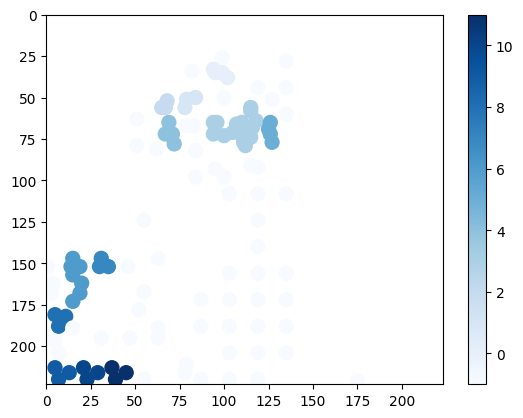

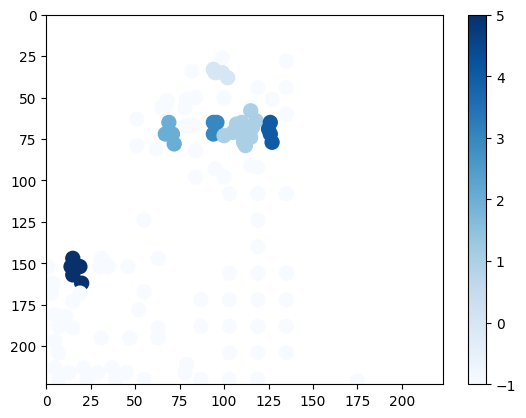

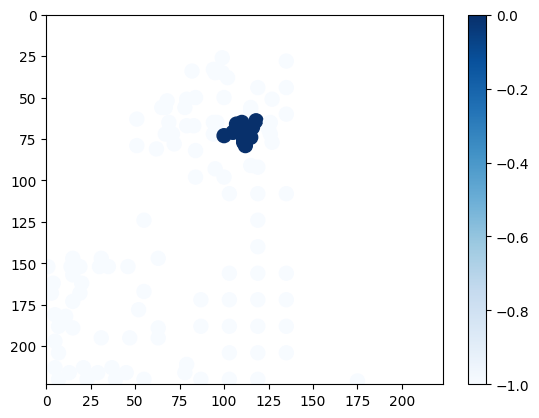

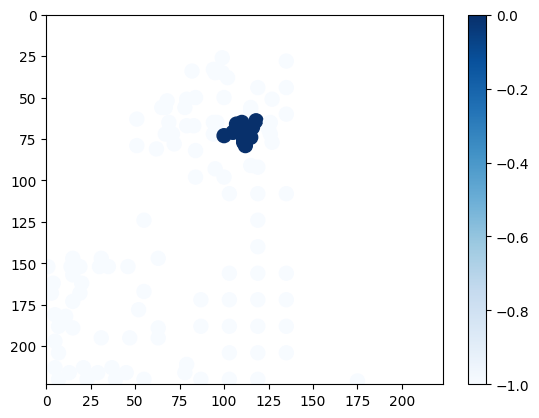

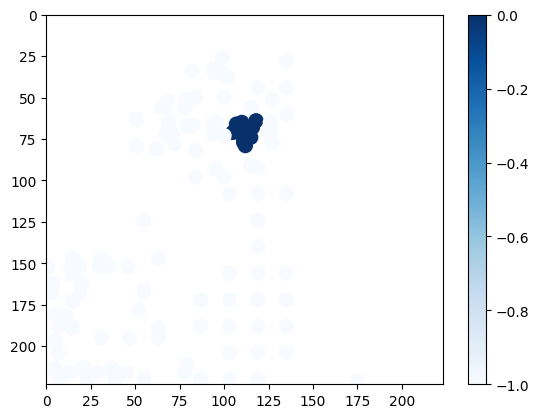

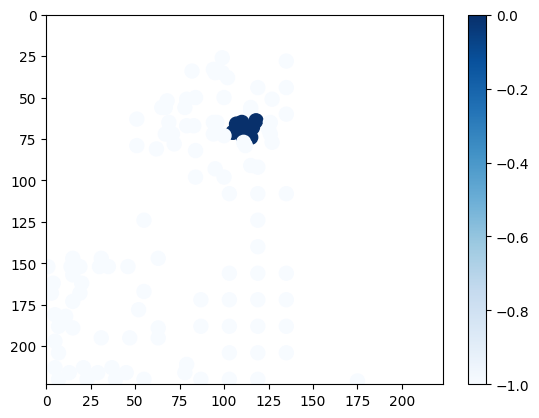

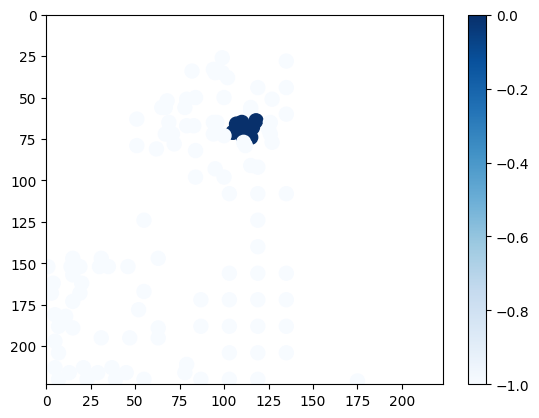

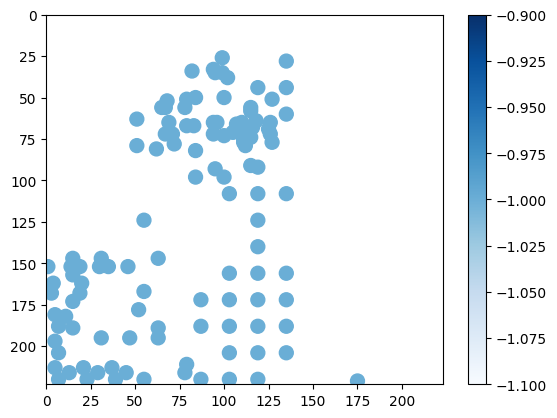

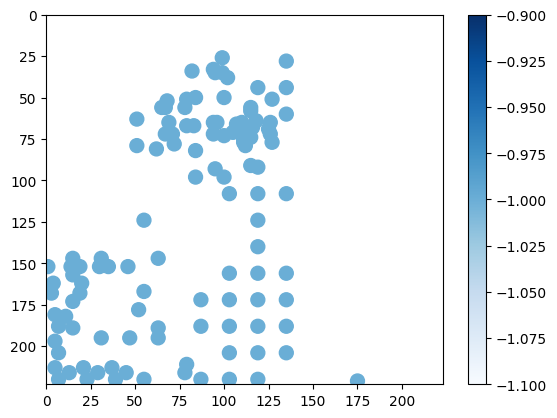

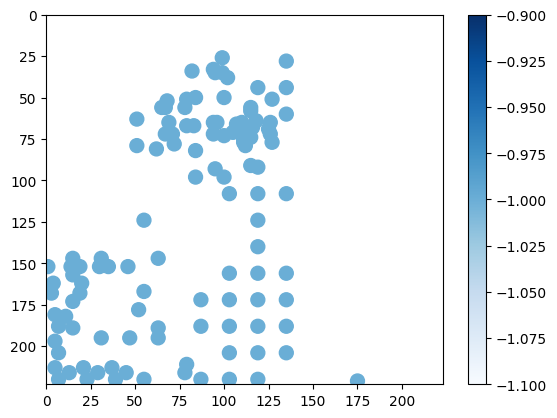

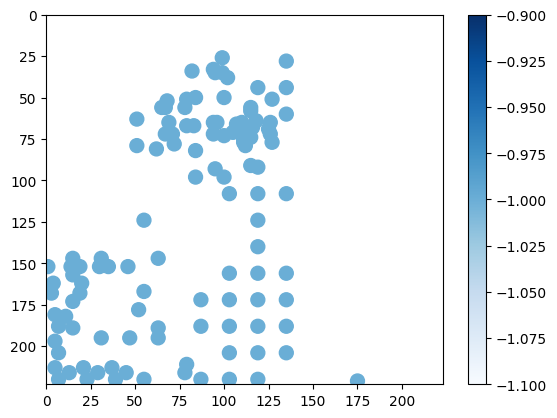

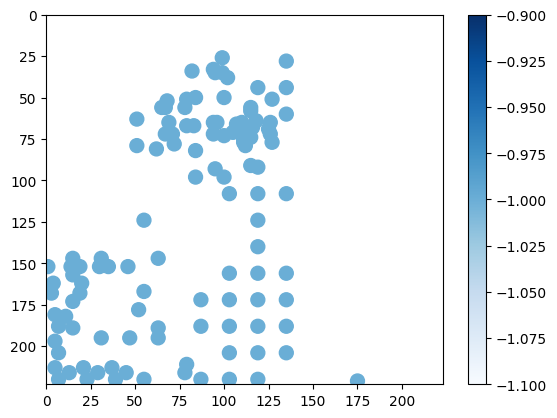

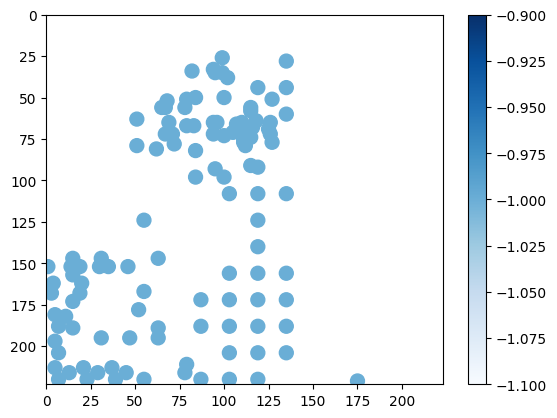

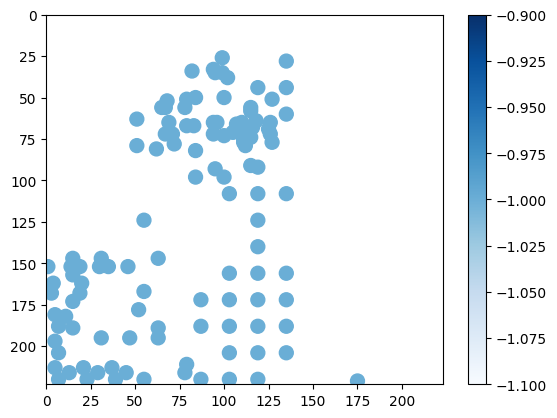

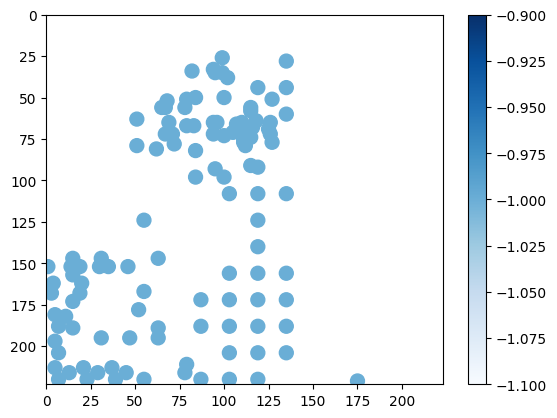

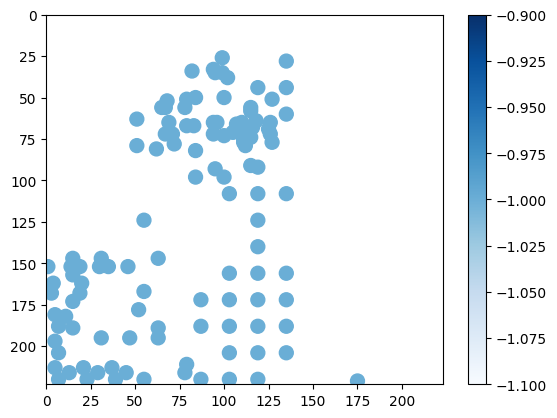

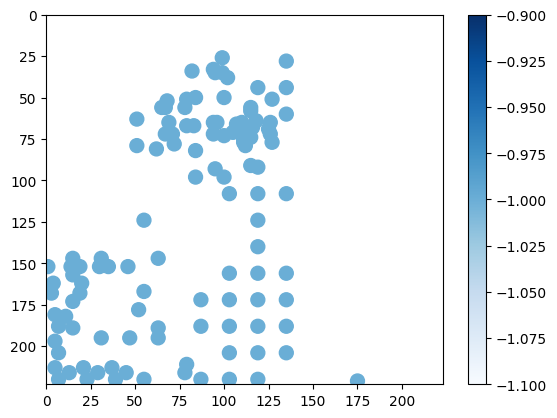

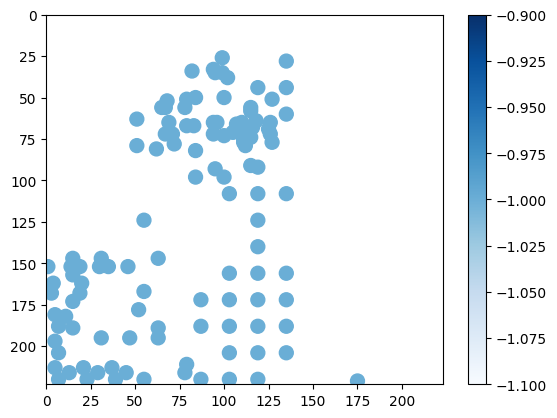

In [40]:
for i in range(1, 21):
    db = DBSCAN(eps=8, min_samples=i)
    pred = db.fit_predict(p)
    n_c = set(pred)
    fig, ax = plt.subplots()
    plt.scatter(x, y, s = 100, c = pred, cmap="Blues")
    plt.colorbar()
    plt.xlim(0, 223)
    plt.ylim(223, 0)
    print(len(set(pred)))

(223.0, 0.0)

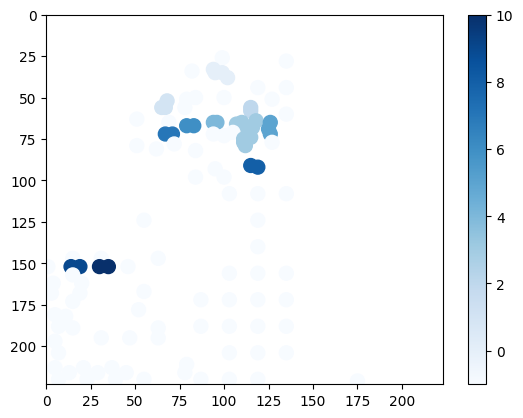

In [78]:
fig, ax = plt.subplots()
plt.scatter(x, y, s=100, c=pred, cmap="Blues")
plt.colorbar()
plt.xlim(0, 223)
plt.ylim(223, 0)

In [ ]:
labels = db.labels_
fig = plt.figure(figsize=(1000,1000))
import seaborn as sns
sns.scatterplot(p[:,0],x[:,1],hue=["cluster-{}".format(x) for x in labels])

In [3]:
inputs.shape

torch.Size([1, 3, 224, 224])

In [5]:
tmp = torch.zeros(1,3,224,224)
tmp.shape

torch.Size([1, 3, 224, 224])

In [6]:
output = model(tmp)

In [9]:
mid = model.blocks[0].block_output
mid = exchange.exchange_tensor_to_array(mid)

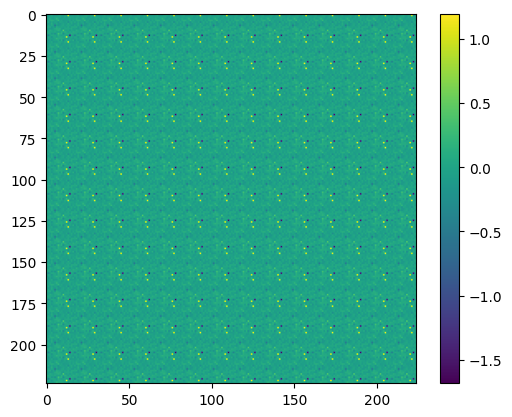

In [15]:
exchange.show_heatmap_with_colorbar(mid)

In [21]:
len(np.where(mid<-0.5)[0])

392

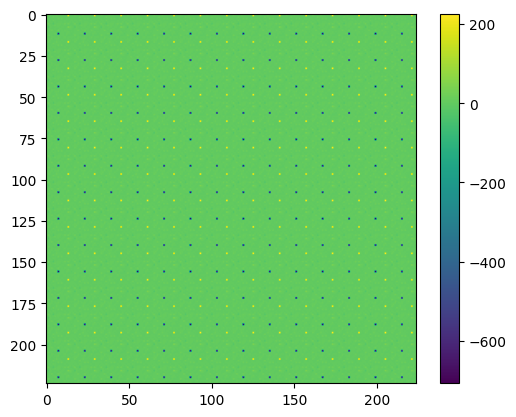

In [29]:
tmp2 = torch.ones(1,3,224,224)
tmp2 *= 255
output2 = model(tmp2)
mid2 = model.blocks[0].block_output
mid2 = exchange.exchange_tensor_to_array(mid2)
exchange.show_heatmap_with_colorbar(mid2)

In [32]:
len(np.where(abs(mid2) < 10)[0])

46648

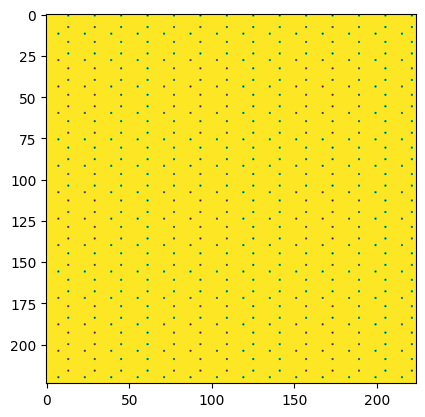

In [36]:
mid2b = np.where(abs(mid2) < 25, 255, 0)
plt.imshow(mid2b)

In [27]:
mid3 = mid + mid2 / 400

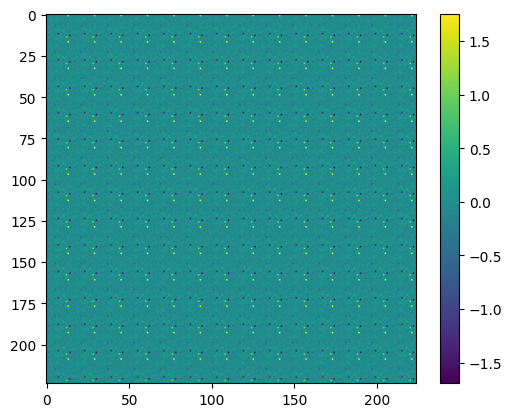

In [28]:
exchange.show_heatmap_with_colorbar(mid3)